# Exploration of Candidate Data Mining Models, and Select the Final Model or Models


<b>Project Title:</b> Spotify Song Popularity Prediction

## Group 4:
- Rahul Nenavath
- Krithika Annaswamy Kannan

### Import Necessary Libraries:

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')

### Loading Data

In [ ]:
!wget 'https://rahul-public-datasets.s3.ap-south-1.amazonaws.com/song-prediction-data.zip'

--2024-03-22 00:24:37--  https://rahul-public-datasets.s3.ap-south-1.amazonaws.com/song-prediction-data.zip
Resolving rahul-public-datasets.s3.ap-south-1.amazonaws.com (rahul-public-datasets.s3.ap-south-1.amazonaws.com)... 52.219.158.34, 16.12.40.30, 52.219.156.50, ...
Connecting to rahul-public-datasets.s3.ap-south-1.amazonaws.com (rahul-public-datasets.s3.ap-south-1.amazonaws.com)|52.219.158.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216068 (1.2M) [application/zip]
Saving to: ‘song-prediction-data.zip’

song-prediction-dat 100%[===================>]   1.16M   909KB/s    in 1.3s    

2024-03-22 00:24:40 (909 KB/s) - ‘song-prediction-data.zip’ saved [1216068/1216068]



In [ ]:
!unzip '/content/song-prediction-data.zip' -d '/content'

Archive:  /content/song-prediction-data.zip
  inflating: /content/song_data.csv  
  inflating: /content/__MACOSX/._song_data.csv  
  inflating: /content/song_info.csv  
  inflating: /content/__MACOSX/._song_info.csv  


In this problem, we will be making use of various attributes of songs on Spotify platform and estimating a given song's popularity. Hence the response variable will be `song_popularity` and rest of the attributes will be input variables. <br><br>From previous Data Exploration and Preparation Milestone, we found attributes like `song_duration_ms`, `key`, `audio_mode`, `speechiness` not don't contribute enough in estimating `song_popularity`. Hence we shall drop these attributes and select only the significant columns!

In [ ]:
k = pd.read_csv('/content/song_data.csv')
k.head(10)['song_name']

0    Boulevard of Broken Dreams
1                    In The End
2             Seven Nation Army
3                    By The Way
4             How You Remind Me
5              Bring Me To Life
6                   Last Resort
7      Are You Gonna Be My Girl
8                Mr. Brightside
9                   Sex on Fire
Name: song_name, dtype: object

In [ ]:
data = pd.read_csv('/content/song_data.csv')

data = data.drop(['song_name',
                  'song_duration_ms',
                  'key', 'audio_mode',
                  'speechiness'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   acousticness      18835 non-null  float64
 2   danceability      18835 non-null  float64
 3   energy            18835 non-null  float64
 4   instrumentalness  18835 non-null  float64
 5   liveness          18835 non-null  float64
 6   loudness          18835 non-null  float64
 7   tempo             18835 non-null  float64
 8   time_signature    18835 non-null  int64  
 9   audio_valence     18835 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.4 MB


### Data Preparation

Splitting the dataset and Normalising it further - Done in the Pt1 of the final code!

In [ ]:
train, test = train_test_split(data, test_size=0.15)
train, validation = train_test_split(train, test_size=0.15)
print(f'Number of samples in Train: {len(train)}, Validation: {len(validation)}, & Test: {len(test)}')

Xtrain, ytrain = train.drop('song_popularity', axis=1), train['song_popularity']
Xvalid, yvalid = validation.drop('song_popularity', axis=1), validation['song_popularity']
Xtest, ytest = test.drop('song_popularity', axis=1), test['song_popularity']

Number of samples in Train: 13607, Validation: 2402, & Test: 2826


In [ ]:
stdscalar = StandardScaler()
stdscalar.fit(Xtrain)
Xtrain_std = stdscalar.transform(Xtrain)
Xvalid_std = stdscalar.transform(Xvalid)
Xtest_std = stdscalar.transform(Xtest)

print(f'Data Dimensions - Train: {Xtrain.shape, ytrain.shape}, Validation: {Xvalid.shape, yvalid.shape}, Test: {Xtest.shape, ytest.shape}')

Data Dimensions - Train: ((13607, 9), (13607,)), Validation: ((2402, 9), (2402,)), Test: ((2826, 9), (2826,))


### Evaluation Criteria

In [ ]:
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"r2": r2, "rmse": rmse}

In [ ]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.show()

def plot_predictions(y_true, y_pred):
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs. True Values')
    plt.show()

### Model Exploration

#### Naive Regression Model

In [ ]:
class NaiveRegressor:
  def __init__(self):
    pass
  def fit(self, X, y):
    self.avg_y = np.mean(y)
  def predict(self, X):
    return np.array([self.avg_y]*len(X))

In [ ]:
nv_reg = NaiveRegressor()
nv_reg.fit(Xtrain_std, ytrain)

valid_preds_naive = nv_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_naive, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -1.0153677050708025e+31
Validation RMSE: 22.641326985200628


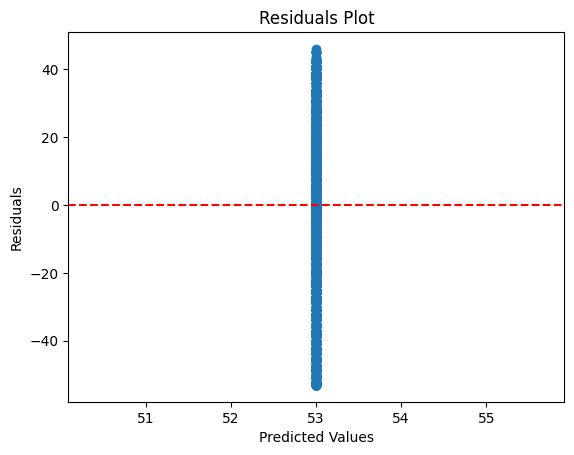

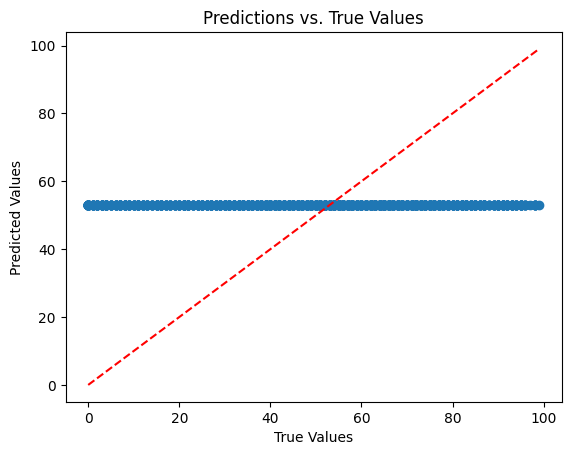

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_naive)
plot_predictions(yvalid, valid_preds_naive)

#### Linear Regression

From the Regression Analysis in previous Data Exploration Milestone, we found r-squared & adjusted r-squared to be only around 0.041 (4.1%). This indicates that the data we have have high non-linearity present and linear models will not be appropriate to capture the patterns. We repeat the Regression Analysis here to reiterate this point.

In [ ]:
X = sm.add_constant(Xtrain_std)
model = sm.OLS(ytrain, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     73.04
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          1.91e-132
Time:                        21:18:02   Log-Likelihood:                -60906.
No. Observations:               13607   AIC:                         1.218e+05
Df Residuals:                   13597   BIC:                         1.219e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.0040      0.182    290.622      0.0

Linear Regression - Validation MSE: 491.50868409228303
Linear Regression - Validation R2 Score: 0.040150154264822824


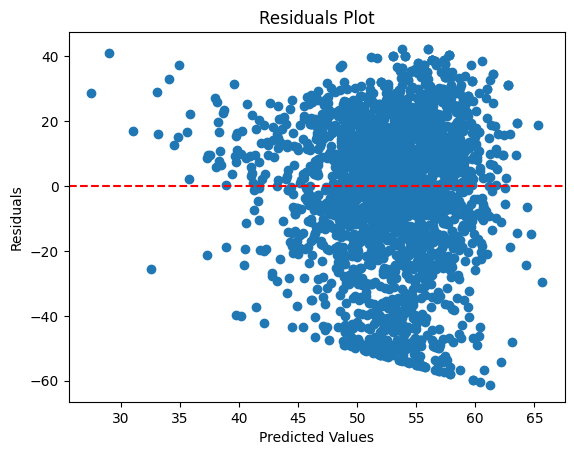

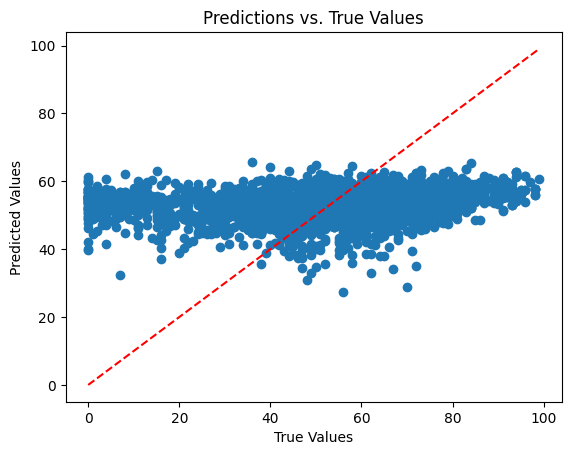

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

linear_reg = LinearRegression()
linear_reg.fit(Xtrain_std, ytrain)

valid_preds_linear = linear_reg.predict(Xvalid_std)
mse_linear = mean_squared_error(yvalid, valid_preds_linear)
r2_linear = r2_score(yvalid, valid_preds_linear)


print(f'Linear Regression - Validation MSE: {mse_linear}')
print(f'Linear Regression - Validation R2 Score: {r2_linear}')


plot_residuals(yvalid, valid_preds_linear)
plot_predictions(yvalid, valid_preds_linear)

**Observations**:
- The condition number is not too big. Indicating we have controlled the Multi-colinearlity.
- The Adjusted R-Square is 0.041 (4.1%) thereby indicating we were able to capture only 4% of the variance from the original data. This strongly suggests that data has high non-linearity present and linear models will not be enough to capture the patterns.

Moving forward we will be exploring non-linear models to capture intricate non-linear models in the data!

#### Decision Trees

In [ ]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(Xtrain_std, ytrain)

valid_preds_dt = dt_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_dt, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -0.13272480202163983
Validation RMSE: 24.43205066707933


In [ ]:
K_folds = 10
scores = cross_val_score(dt_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2')
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: -0.23344223599791256


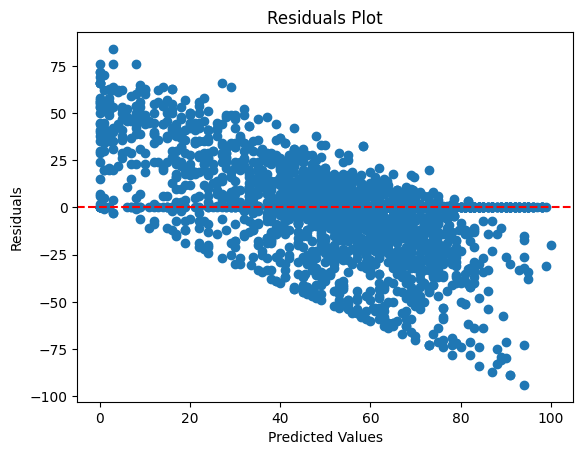

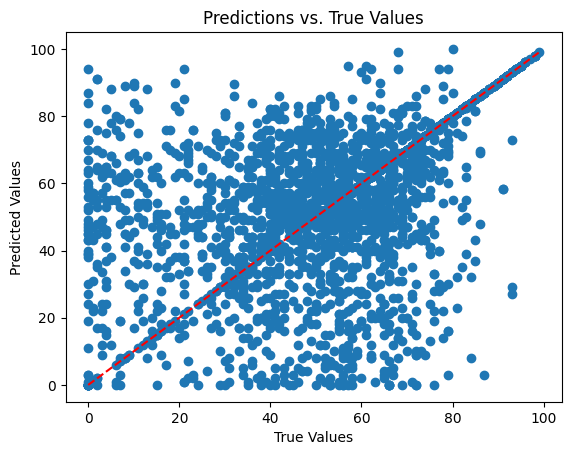

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_dt)
plot_predictions(yvalid, valid_preds_dt)


#### KNN Regressor

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors=100)
knn_reg.fit(Xtrain_std, ytrain)

valid_preds_knn = knn_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_knn, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -12.489792671065425
Validation RMSE: 21.77401105566274


In [ ]:
K_folds = 10
scores = cross_val_score(knn_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2')
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.07474679826697225


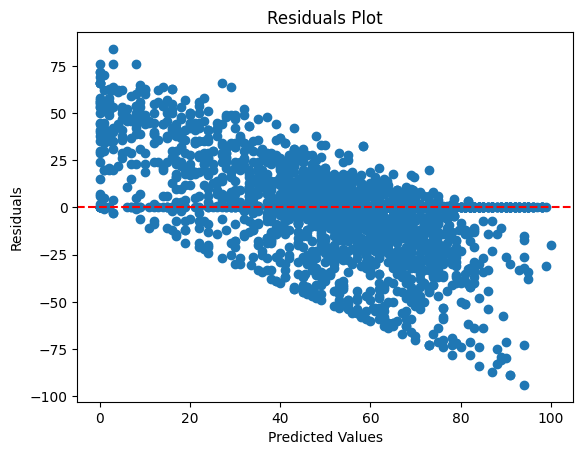

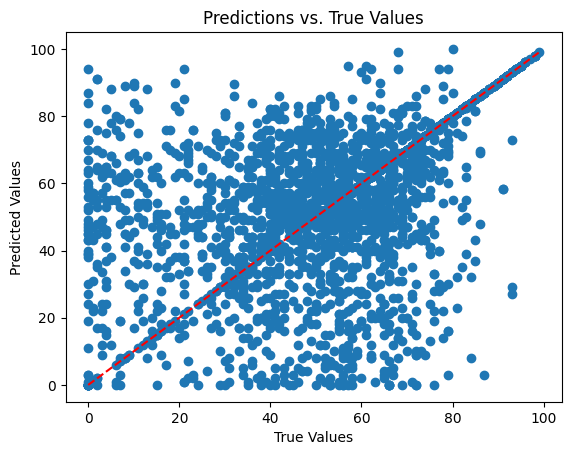

In [ ]:
plot_residuals(yvalid, valid_preds_dt)
plot_predictions(yvalid, valid_preds_dt)

#### Random Forest

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(Xtrain_std, ytrain)

valid_preds_rf = rf_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_rf, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -0.8311849314711972
Validation RMSE: 18.005634695691946


In [ ]:
K_folds = 10
scores = cross_val_score(rf_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2')
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.35821340602442214


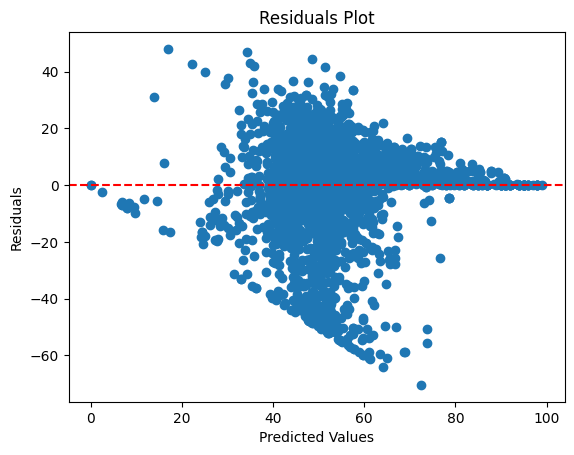

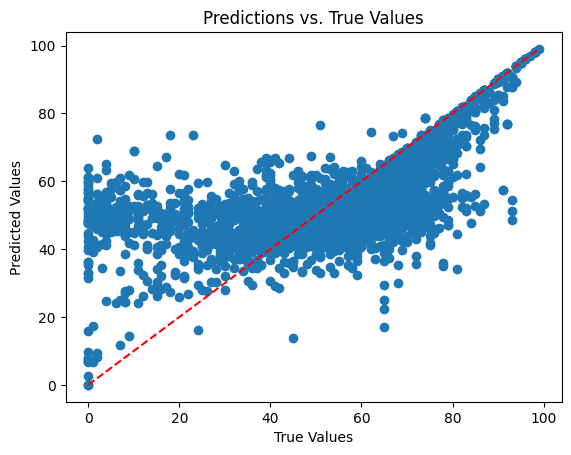

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_rf)
plot_predictions(yvalid, valid_preds_rf)

#### XGBoost

In [ ]:
xg_reg = xgb.XGBRegressor(n_estimators=1000)
xg_reg.fit(Xtrain_std, ytrain,
           eval_set=[(Xvalid_std, yvalid)],
           eval_metric="rmse",
           early_stopping_rounds=10)

valid_preds_xgb = xg_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_xgb, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

[0]	validation_0-rmse:22.09764
[1]	validation_0-rmse:21.77153
[2]	validation_0-rmse:21.54258
[3]	validation_0-rmse:21.37785
[4]	validation_0-rmse:21.22884
[5]	validation_0-rmse:21.14618
[6]	validation_0-rmse:21.07749
[7]	validation_0-rmse:21.01020
[8]	validation_0-rmse:20.93526
[9]	validation_0-rmse:20.89691
[10]	validation_0-rmse:20.85570
[11]	validation_0-rmse:20.82848
[12]	validation_0-rmse:20.75904
[13]	validation_0-rmse:20.72950
[14]	validation_0-rmse:20.69954
[15]	validation_0-rmse:20.64368
[16]	validation_0-rmse:20.62324
[17]	validation_0-rmse:20.62442
[18]	validation_0-rmse:20.61858
[19]	validation_0-rmse:20.58188
[20]	validation_0-rmse:20.57297
[21]	validation_0-rmse:20.54920
[22]	validation_0-rmse:20.52830
[23]	validation_0-rmse:20.53200
[24]	validation_0-rmse:20.49064
[25]	validation_0-rmse:20.47927
[26]	validation_0-rmse:20.47221
[27]	validation_0-rmse:20.43141
[28]	validation_0-rmse:20.41165
[29]	validation_0-rmse:20.39410
[30]	validation_0-rmse:20.36185
[31]	validation_0-

In [ ]:
K_folds = 10
scores = cross_val_score(xg_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2', n_jobs=-1)
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.23365875089291857


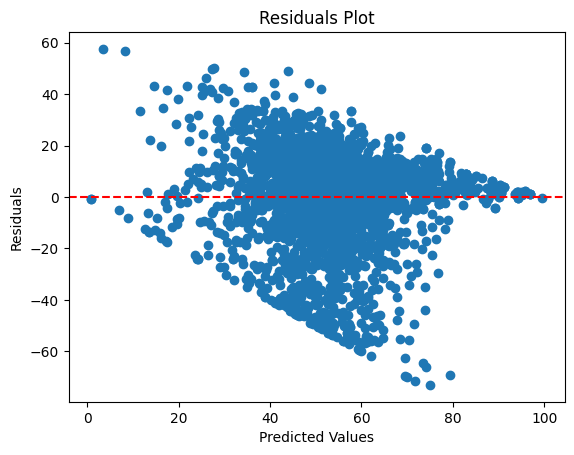

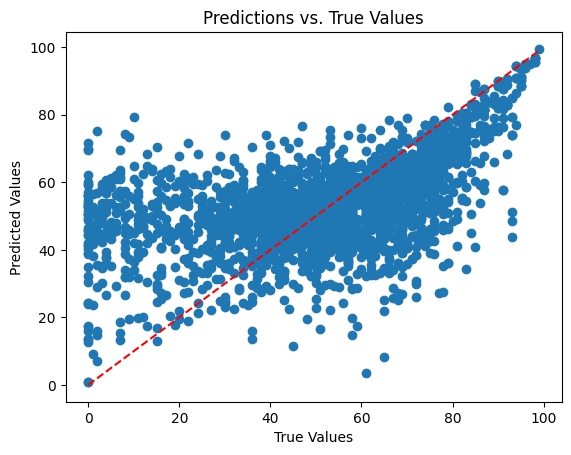

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_xgb)
plot_predictions(yvalid, valid_preds_xgb)

#### Gradient Boosting

In [ ]:
params = {'n_estimators': 1500,
          'max_depth': 5,
          'min_samples_split': 3,
          'min_samples_leaf': 2,
          'learning_rate': 0.01
         }
gbd_reg = GradientBoostingRegressor(**params)
gbd_reg.fit(Xtrain_std, ytrain)

valid_preds_gb = gbd_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_gb, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -5.028782343713673
Validation RMSE: 20.398126584024244


In [ ]:
K_folds = 10
scores = cross_val_score(gbd_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2', n_jobs=-1)
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.18550308169529459


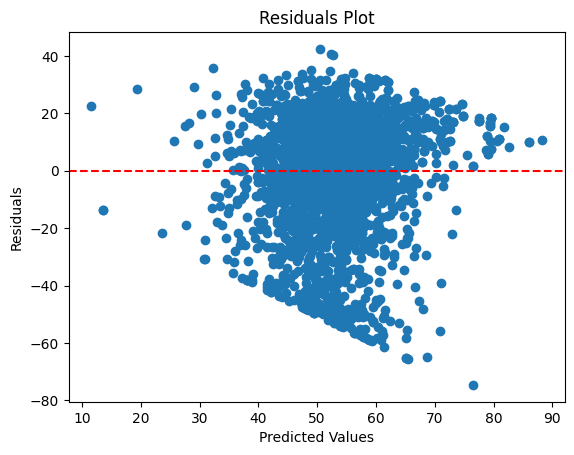

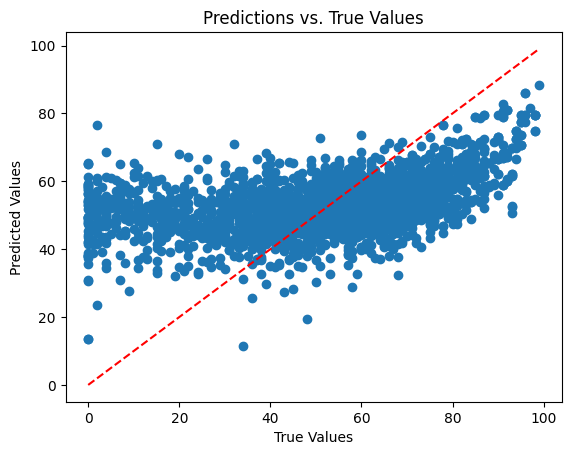

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_gb)
plot_predictions(yvalid, valid_preds_gb)

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define models and their respective predictions
models = ['Naive', 'Linear Regression', 'Decision Tree', 'KNN Regressor', 'Random Forest', 'XGBoost', 'Gradient Boosting']
predictions = [valid_preds_naive, valid_preds_linear, valid_preds_dt, valid_preds_knn, valid_preds_rf, valid_preds_xgb, valid_preds_gb]

# Compute performance metrics for each model
mse = [mean_squared_error(yvalid, preds) for preds in predictions]
r2 = [r2_score(yvalid, preds) for preds in predictions]
rmse = [np.sqrt(m) for m in mse]  # Calculate RMSE

# Create a summary table
summary_table = pd.DataFrame({
    'Model': models,
    'MSE': mse,
    'RMSE': rmse,
    'R2 Score': r2
})

print(summary_table)


               Model         MSE       RMSE  R2 Score
0              Naive  512.629688  22.641327 -0.001096
1  Linear Regression  491.508684  22.169995  0.040150
2      Decision Tree  596.925100  24.432051 -0.165714
3      KNN Regressor  474.107557  21.774011  0.074132
4      Random Forest  324.202881  18.005635  0.366876
5            XGBoost  377.212111  19.421949  0.263356
6  Gradient Boosting  416.083568  20.398127  0.187445


The most popular song is: Foreplay / Long Time


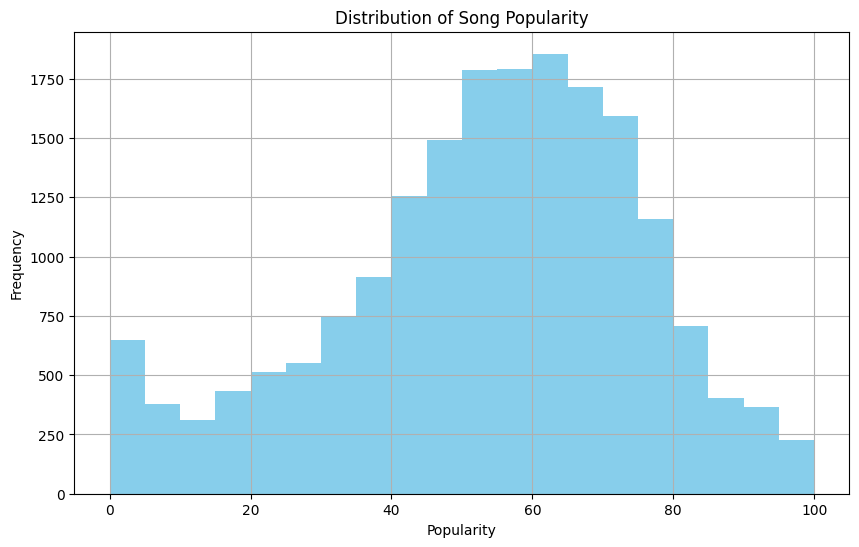

In [ ]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(Xtrain_std, ytrain)

# Predict popularity for validation set
y_pred_valid = rf_model.predict(Xvalid_std)

# Identify the most popular song
most_popular_index = y_pred_valid.argmax()
most_popular_song = k.iloc[most_popular_index]['song_name']
print(f"The most popular song is: {most_popular_song}")

# For example, let's visualize the distribution of song popularity
plt.figure(figsize=(10, 6))
plt.hist(k['song_popularity'], bins=20, color='skyblue')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

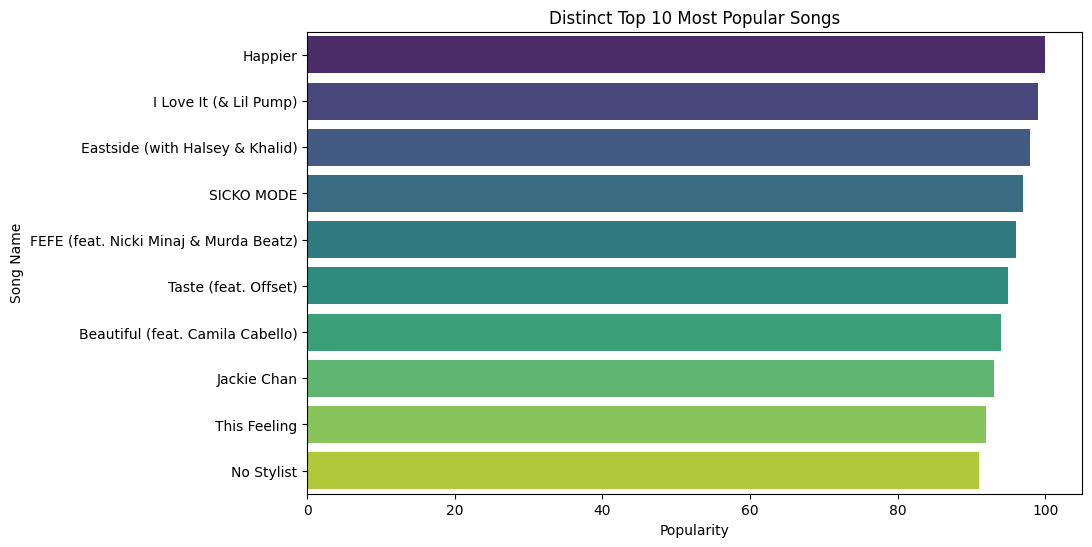

In [ ]:
top_n = 10  # Number of distinct top songs you want

# Sort the dataset by popularity in descending order
sorted_songs = k.sort_values(by='song_popularity', ascending=False)

# Extract distinct top songs
distinct_top_songs = sorted_songs.drop_duplicates(subset='song_popularity').head(top_n)

# Visualize the distinct top N popular songs
plt.figure(figsize=(10, 6))
sns.barplot(x='song_popularity', y='song_name', data=distinct_top_songs, palette='viridis')
plt.title(f'Distinct Top {top_n} Most Popular Songs')
plt.xlabel('Popularity')
plt.ylabel('Song Name')
plt.show()

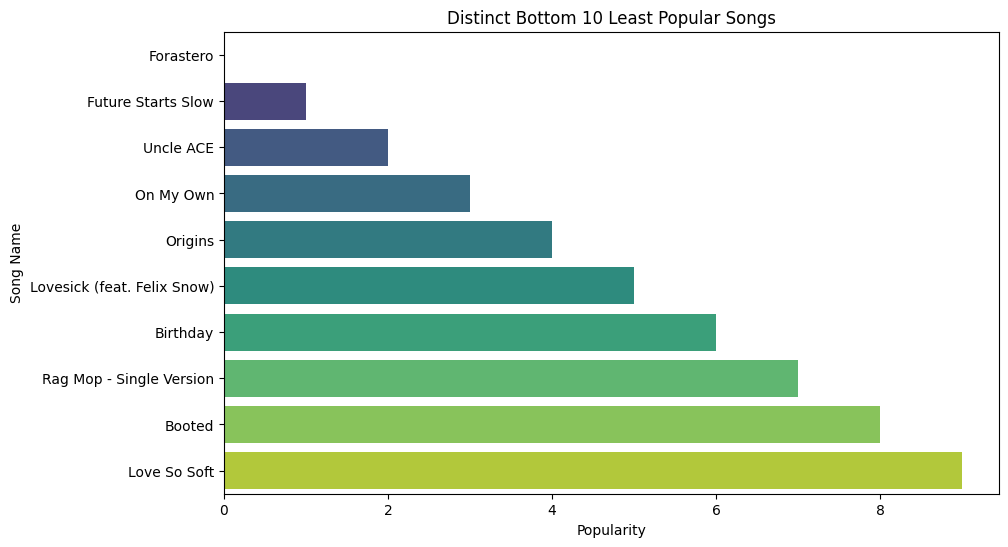

In [ ]:
# Get distinct bottom N popular songs
bottom_n = 10  # Number of distinct bottom songs you want

# Sort the dataset by popularity in ascending order to get the least popular songs
sorted_songs = k.sort_values(by='song_popularity', ascending=True)

# Extract distinct bottom songs
distinct_bottom_songs = sorted_songs.drop_duplicates(subset='song_popularity').head(bottom_n)

# Visualize the distinct bottom N popular songs
plt.figure(figsize=(10, 6))
sns.barplot(x='song_popularity', y='song_name', data=distinct_bottom_songs, palette='viridis')
plt.title(f'Distinct Bottom {bottom_n} Least Popular Songs')
plt.xlabel('Popularity')
plt.ylabel('Song Name')
plt.show()